In [1]:
%load_ext autoreload
%autoreload 2

import tracemalloc
from collections import Counter
import linecache
import os

def display_top(snapshot, key_type='lineno', limit=3):
    snapshot = snapshot.filter_traces((
        tracemalloc.Filter(False, "<frozen importlib._bootstrap>"),
        tracemalloc.Filter(False, "<unknown>"),
    ))
    top_stats = snapshot.statistics(key_type)

    print("Top %s lines" % limit)
    for index, stat in enumerate(top_stats[:limit], 1):
        frame = stat.traceback[0]
        # replace "/path/to/module/file.py" with "module/file.py"
        filename = os.sep.join(frame.filename.split(os.sep)[-2:])
        print("#%s: %s:%s: %.1f KiB"
              % (index, filename, frame.lineno, stat.size / 1024))
        line = linecache.getline(frame.filename, frame.lineno).strip()
        if line:
            print('    %s' % line)

    other = top_stats[limit:]
    if other:
        size = sum(stat.size for stat in other)
        print("%s other: %.1f KiB" % (len(other), size / 1024))
    total = sum(stat.size for stat in top_stats)
    print("Total allocated size: %.1f KiB" % (total / 1024))

tracemalloc.start()


In [2]:
from utils_v1 import *


In [3]:
from icecream import ic

import numpy as np
from src.dataset import (
    MultipleDates,
    PA, PADeforestationTime, PADistanceMap, PAMultipleDates,
    MTDeforestationTime,
    MTMultipleDates
)

# from src.dataset_legacy import MTDeforestationTime
from src import training_generator as generator
from src.patchesHandler import PatchesHandler, PatchesHandlerMultipleDates, PatchesHandlerEvidential

from src.trainer.evidential import TrainerEvidential, TrainerEvidentialUEO
import src.trainer.evidential as evidential

from mpl_toolkits.axes_grid1 import make_axes_locatable

import cv2
from src import metrics as _metric


In [4]:
from enum import Enum
UncertaintyMethod = Enum('Predictor', 'pred_var MI pred_entropy KL pred_entropy_single evidential')
uncertaintyMethod = "evidential"


In [5]:

config = {
	"training": False,
	"learning_rate": 1e-4, # 1e-3
	"weights": [0.1, 0.9, 0],
	"save_probabilities": False,
	"loadInference": False,
	"addPastDeforestationInput": True,
	"inference_times": 1,
	"Uncertainty": {
		"annealing_step": 10*375 # 1875, 10*375*10
	},
	"uncertainty_method": uncertaintyMethod,
	"evidence_function": evidential.relu_evidence,
#	"loss": evidential.loss_evidential_dice
}

# config["loss"] = config["loss"](config["weights"])
'''
if config["training"] == True:
	dates = [2017, 2018]
else:
	dates = [2018, 2019]
if config["training"] == True:
	dates = [2018, 2019]
else:
	dates = [2019, 2020]
'''
site = 'PA'
if site == 'PA':
	# dates = [2018, 2019]
	dates = [2017, 2018]

	dataset = PAMultipleDates(dates = dates, # dates = [2017, 2018, 2019]. [2018, 2019]. [2015, 2016, 2017, 2018]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
elif site == 'MT':
	dates = [2019, 2020]
	dataset = MTMultipleDates(dates = dates, # dates = [2016,2017,2018,2019]
		addPastDeforestationInput = config['addPastDeforestationInput'],
		borderBuffer = 2)	
# dataset = MTDeforestationTime()	
# [2016, 2017, 2018]

ic(dates)


if issubclass(type(dataset), MultipleDates):
	patchesHandler = PatchesHandlerEvidential(
		dataset)
else:
	patchesHandler = PatchesHandler()

# exp = 170
# exp = 155
exp = 155 # relu
# exp = 171 # softsign
## exp = 173
exp = 191
exp = 192
exp = 195

# if config["training"] == True:
# trainer = TrainerEvidentialUEO(config, dataset, patchesHandler)
trainer = TrainerEvidential(config, dataset, patchesHandler)

trainer.defineExperiment(exp)


ic| list(self.date_ids): [0]
ic| self.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]
ic| dates: [2019, 2020]
ic| self.input_image_shape: 21
ic| self.dataset.image_channels: [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]]


In [6]:
exp

195

In [7]:
trainer.setExperimentPath()
trainer.createLogFolders()

In [8]:
# ic(type(dataset), exp, dataset.dates)


In [9]:

trainer.loadLabel()

D:/Jorge/datasets/deforestation/MT/deforestation_past_years.tif
Loaded deforestation past years


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Label where deforestation past years is actual date (2020) = 1


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation different from 0 (no deforestation)


ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))


Past deforestation before 2008 is 2
D:/Jorge/datasets/deforestation/MT/deforestation_before_2008/deforestation_before_2008_MT.tif


ic| np.unique(label_past_deforestation_before_2008, return_counts=True): (array([  0, 215], dtype=uint8), array([122623260,  52380640], dtype=int64))
ic| np.unique(deforestation_past_years, return_counts=True): (array([   0, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
                                                                    2018, 2019, 2020, 2021], dtype=uint16),
                                                              array([161124576,   1332784,    240796,    338545,    313901,    287191,
                                                                       708581,    648966,    876898,   1007787,   1098901,   1054092,
                                                                      2096062,   2473828,   1400992], dtype=int64))
ic| label_per_date.shape: (16795, 10420, 1)


Mask label shape:  
 (16795, 10420, 1) 
 Unique values:  
 [0 1 2]


In [10]:

# Creating tile mask
trainer.createTrainValTestTiles()


Tiles size:  3359 2084
Mask size:  (16795, 10420)


In [11]:

trainer.label_mask.dtype

dtype('uint8')

In [12]:

trainer.getLabelCurrentDeforestation()

In [13]:

trainer.loadInputImage()

ic| image_stack.shape: (16795, 10420, 21)


Image shape:  (16795, 10420, 21)
mask:  (16795, 10420)
image stack:  (16795, 10420, 21)
ref : (16795, 10420, 1)


In [14]:

np.unique(trainer.image_stack[...,0], return_counts=True)

(array([0.        , 0.07692308, 0.15384616, 0.23076925, 0.30769232,
        0.3846154 , 0.4615385 , 0.53846157, 0.61538464, 0.6923077 ,
        0.7692308 , 0.84615386, 0.923077  , 1.        ], dtype=float32),
 array([112618766,   2096062,   1054083,   1098901,   1007787,    876898,
           648966,    708581,    287191,    313901,    338545,    240796,
          1332783,  52380640], dtype=int64))

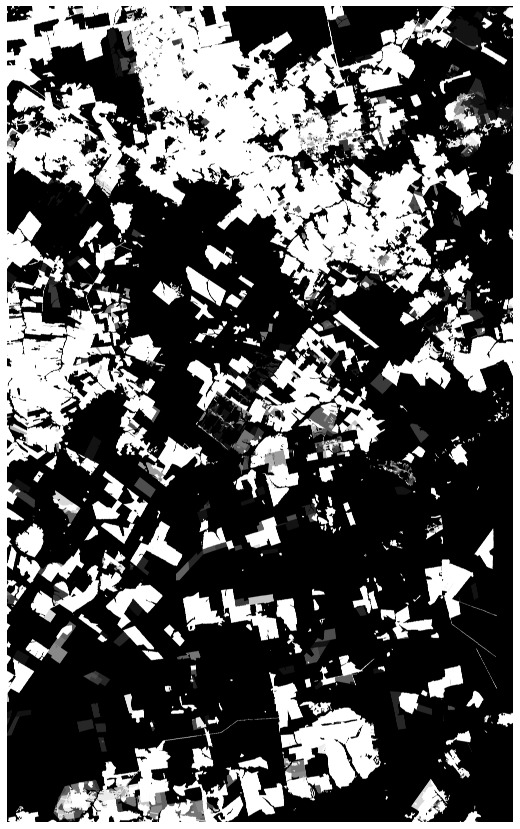

In [15]:

trainer.logger.plotFigure(trainer.image_stack[...,0], 
    name='image_stack_first_channel', cmap=plt.cm.gray, savefig=False)

In [16]:

trainer.getImageChannels()

ic| self.image_stack.shape: (16795, 10420, 21)
ic| self.channels: 21


In [17]:

trainer.getTrainValTestMasks()

Training tiles:  [2, 4, 5, 6, 7, 12, 14, 15, 18, 21, 23, 24]
Validation tiles:  [9, 11, 25]
Test tiles:  [1, 3, 8, 10, 13, 16, 17, 19, 20, 22]


In [18]:

if config["training"] == True:
    # Extracting patches from the idx matrix
    trainer.createIdxImage()


In [19]:
if config["training"] == True:
    trainer.extractCoords()

In [20]:
if config["training"] == True:
    trainer.trainTestSplit()

In [21]:
if config["training"] == True:
    trainer.label_mask.shape

In [22]:
if config["training"] == True:
    if type(dataset) != PADeforestationTime and type(dataset) != MTDeforestationTime:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)

    else:
        trainer.logger.plotFigure(trainer.label_mask[...,-1], 
            name='Reference', cmap=plt.cm.gray, savefig=False)



In [23]:
if config["training"] == True:
    np.unique(trainer.label_mask)

In [24]:
if config["training"] == True:
    print(trainer.coords_train)

In [25]:
if config["training"] == True:
    trainer.retrieveSamplesOfInterest()

In [26]:
if config["training"] == True:
    inputSnipShow = True

In [27]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 2800)


In [28]:
if config["training"] == True:
    if inputSnipShow == True:
        trainer.snipDataset(idx = 97)


In [29]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 1200)

In [30]:
if config["training"] == True:
    if inputSnipShow == True:

        trainer.snipDataset(idx = 400)

In [31]:
if config["training"] == True:
    trainer.getGenerators()


In [32]:
if config["training"] == True:
    trainer.fixChannelNumber()

In [33]:
if config["training"] == True:
    print(trainer.path_exp)

In [34]:
if config["training"] == True:
    print(trainer.channels)

In [35]:
if config["training"] == True:
    print(trainer.image_stack.shape)

In [36]:
# trainer.weights = [0.01, 0.99, 0]
trainer.weights

[0.1, 0.9, 0]

### Evidential metrics

In [37]:
if config["training"] == True:
    trainer.train()

In [38]:
if config["training"] == True:
    trainer.plotHistory()


In [39]:
if config["training"] == True:
    trainer.plotLossTerms()

In [40]:
if config["training"] == True:
    trainer.plotAnnealingCoef()

In [41]:
def draw_EDL_results(K, history):
    # train_acc1, train_ev_s, train_ev_f, test_acc1, test_ev_s, test_ev_f 
    # calculate uncertainty for training and testing data for correctly and misclassified samples
    '''
    K: known classes
    '''
    train_u_succ = K / (K+np.array(history['evidential_success']))
    train_u_fail = K / (K+np.array(history['evidential_fail']))
    test_u_succ  = K / (K+np.array(history['val_evidential_success']))
    test_u_fail  = K / (K+np.array(history['val_evidential_fail']))
    
    f, axs = plt.subplots(2, 2)
    f.set_size_inches([10,10])
    
    axs[0,0].plot(history['evidential_success'],c='r',marker='+')
    axs[0,0].plot(history['evidential_fail'],c='k',marker='x')
    axs[0,0].set_title('Train Data')
    axs[0,0].set_xlabel('Epoch')
    axs[0,0].set_ylabel('Estimated total evidence for classification') 
    axs[0,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[0,1].plot(train_u_succ,c='r',marker='+')
    axs[0,1].plot(train_u_fail,c='k',marker='x')
    axs[0,1].plot(history['acc'],c='blue',marker='*')
    axs[0,1].set_title('Train Data')
    axs[0,1].set_xlabel('Epoch')
    axs[0,1].set_ylabel('Estimated uncertainty for classification')
    axs[0,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    
    axs[1,0].plot(history['val_evidential_success'],c='r',marker='+')
    axs[1,0].plot(history['val_evidential_fail'],c='k',marker='x')
    axs[1,0].set_title('Test Data')
    axs[1,0].set_xlabel('Epoch')
    axs[1,0].set_ylabel('Estimated total evidence for classification') 
    axs[1,0].legend(['Correct Clasifications','Misclasifications'])
    
    axs[1,1].plot(test_u_succ,c='r',marker='+')
    axs[1,1].plot(test_u_fail,c='k',marker='x')
    axs[1,1].plot(history['val_acc'],c='blue',marker='*')
    axs[1,1].set_title('Test Data')
    axs[1,1].set_xlabel('Epoch')
    axs[1,1].set_ylabel('Estimated uncertainty for classification')
    axs[1,1].legend(['Correct clasifications','Misclasifications', 'Accuracy'])
    

In [42]:
if config["training"] == True:
    draw_EDL_results(trainer.class_n, trainer.history.history)

    plt.figure(5)
    plt.plot(trainer.history.history['evidential_success'],c='r',marker='+')
    plt.plot(trainer.history.history['evidential_fail'],c='k',marker='x')
    plt.title('Train Data')
    plt.xlabel('Epoch')
    plt.ylabel('Estimated total evidence for classification') 
    plt.legend(['Correct Clasifications','Misclasifications'])


In [43]:
trainer.image_stack.shape

(16795, 10420, 21)

In [44]:
if type(trainer.dataset) != PADeforestationTime and type(trainer.dataset) != MTDeforestationTime:
    trainer.patchesHandler.dataset.image_channels[-1]

In [45]:
if issubclass(type(dataset), MultipleDates):
	trainer.channels = trainer.patchesHandler.input_image_shape
	trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
	trainer.label_mask = trainer.label_mask[...,-1]

In [46]:
trainer.image_stack.shape

(16795, 10420, 21)

In [47]:
trainer.setPadding()

-5.0 -12.0


In [48]:
trainer.infer()

ic| self.path_models+ '/' + self.method +'_'+str(0)+'.h5': 'D:/Jorge/datasets/deforestation/experiments/MT/exp195/models/resunet_0.h5'


time:  0


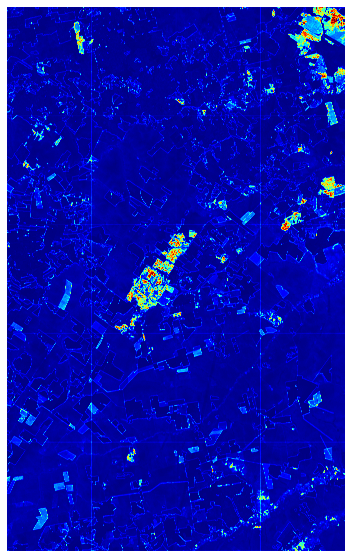

In [49]:
trainer.logger.plotFigure(trainer.u_reconstructed, 
            name='Uncertainty', cmap='jet', savefig=False, figsize=(10,10))

In [50]:
trainer.loadPredictedProbabilities()


In [51]:
trainer.prob_rec.shape

(16800, 10432)

In [52]:
trainer.getMeanProb()

In [53]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.014820687
    np.mean(value): 0.041021463
    np.max(value): 0.9215645


In [54]:
ic(trainer.mean_prob.shape)

ic| trainer.mean_prob.shape: (16800, 10432)


(16800, 10432)

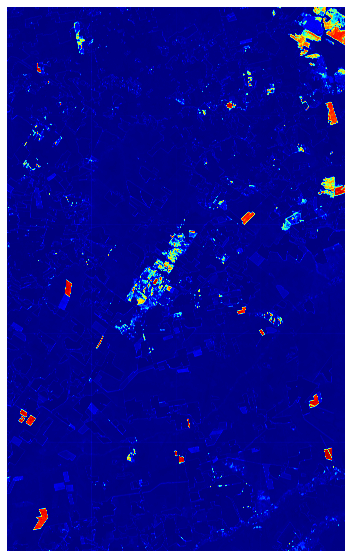

In [55]:
trainer.unpadMeanProb()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

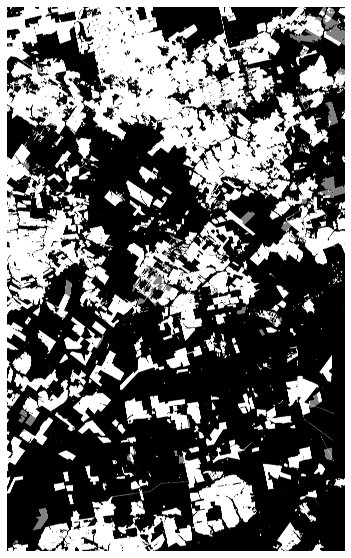

In [56]:
trainer.logger.plotFigure(trainer.label_mask, 
            name='Reference mask', figsize=(10,10), cmap=plt.cm.gray, savefig=True)

In [57]:
trainer.squeezeLabel()

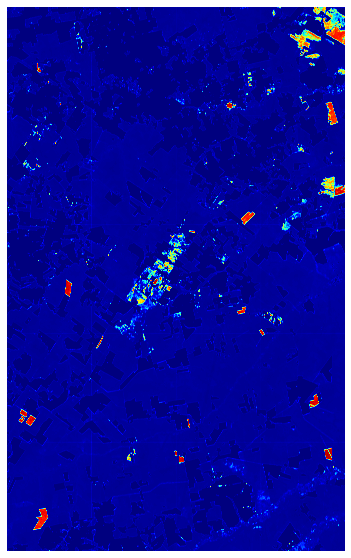

In [58]:
trainer.setMeanProbNotConsideredAreas()
trainer.logger.plotFigure(trainer.mean_prob, 
            name='Mean predicted probability', figsize=(10,10), cmap='jet', savefig=False)

In [59]:
trainer.logger.getStats(trainer.mean_prob)

ic| np.min(value): 0.0
    np.mean(value): 0.030872889
    np.max(value): 0.9215645


In [60]:
print(trainer.label_mask.shape)

(16795, 10420)


In [61]:
trainer.getLabelTest()

(44657480,)
(array([0, 1], dtype=uint8), array([43783238,   874242], dtype=int64))


In [62]:
trainer.getMAP()

82.98


In [63]:
trainer.prob_rec.shape

(16800, 10432)

In [64]:
trainer.preprocessProbRec()
print(trainer.prob_rec.shape)

(16800, 10432, 1)


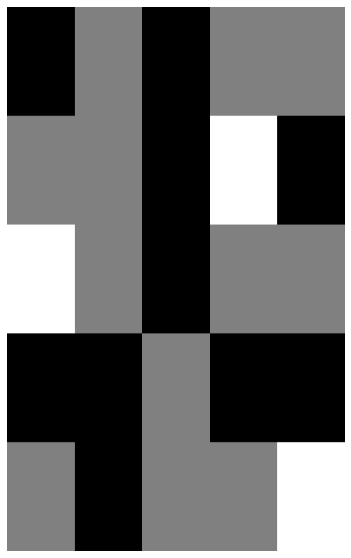

In [65]:
trainer.logger.plotFigure(trainer.mask_tr_val, 
            name=trainer.dataset.site + trainer.title_name + ' Train val mask.png', figsize=(10,10), savefig=False)

In [66]:
trainer.getLabelCurrentDeforestation()

In [67]:
trainer.applyProbabilityThreshold()

(16795, 10420)
(array([0., 1.], dtype=float32), array([172697600,   2306300], dtype=int64))


ic| self.predicted_unpad.shape: (16795, 10420)
    self.predicted.shape: (16795, 10420)


In [68]:
trainer.getTestValues()

ic| predicted_test.shape: (70001560,)
ic| predicted_test.shape: (44657480,)


In [69]:
trainer.removeSmallPolygons()

ic| np.unique(predicted, return_counts=True): (array([0., 1.], dtype=float32), array([172697600,   2306300], dtype=int64))
    np.unique(predicted_larger_than_min_area, return_counts=True): (array([0., 1.], dtype=float32), array([172912510,   2091390], dtype=int64))
ic| np.unique(ignored_polygons, return_counts=True): (array([0., 1.], dtype=float32), array([174788990,    214910], dtype=int64))


In [70]:
trainer.calculateMetrics()

ic| self.f1: 78.11, self.precision: 83.23, self.recall: 73.57


In [71]:
trainer.getValidationValuesForMetrics()
trainer.calculateMetricsValidation()

ic| self.label_mask_val.shape: (21000468,)
ic| self.label_mask_val_valid.shape: (11789939,)
ic| f1_val: 97.94
    precision_val: 99.05
    recall_val: 96.86
    mAP_val: 99.1


In [72]:
calculateMAPWithoutSmallPolygons = False
if calculateMAPWithoutSmallPolygons == True:
    trainer.calculateMAPWithoutSmallPolygons()

In [73]:
trainer.getErrorMask()

(array([0., 1.], dtype=float32), array([174142814,    861086], dtype=int64))


In [74]:
'''

import types

trainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)
'''


'\n\nimport types\n\ntrainer.getErrorMaskToShowRGB = types.MethodType(getErrorMaskToShowRGB, trainer)\n'

In [75]:
trainer.getErrorMaskToShowRGB()

[0. 1.]


In [76]:
predicted_unpad_to_show = trainer.predicted_unpad.copy()

predicted_unpad_to_show[trainer.label_mask == 2] = 0
print(np.unique(predicted_unpad_to_show))

[0. 1.]


In [77]:
predicted_unpad_to_show.shape

(16795, 10420)

In [78]:

'''
trainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)
'''

'\ntrainer.logger.plotFigure = types.MethodType(trainer.logger.plotFigure, trainer)\n'

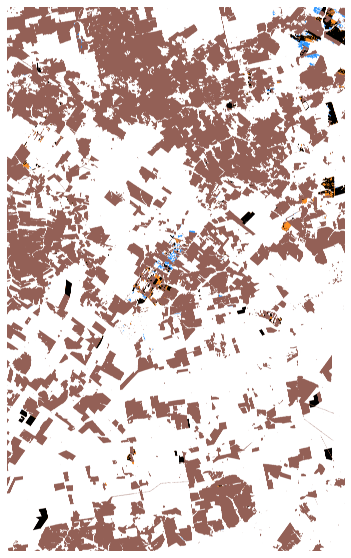

In [79]:
trainer.logger.plotFigure(trainer.error_mask_to_show_rgb[...,::-1], 
            name=trainer.dataset.site + trainer.title_name + ' error mask color.png', 
            figsize=(10,10), savefig=True, dpi=300)

In [80]:
trainer.setUncertainty()

In [81]:
trainer.getValidationValues2()
trainer.getTestValues2()

ic| self.label_mask.shape: (16795, 10420)
ic| self.mask_amazon_ts.shape: (16795, 10420)
ic| self.label_mask_test.shape: (70001560,)
ic| self.error_mask_test.shape: (44573051,)


In [82]:
trainer.getUncertaintyToShow()
trainer.logger.getStats(trainer.uncertainty_to_show)


ic| np.min(value): 0.0, np.mean(value): 0.06658947, np.max(value): 1.0


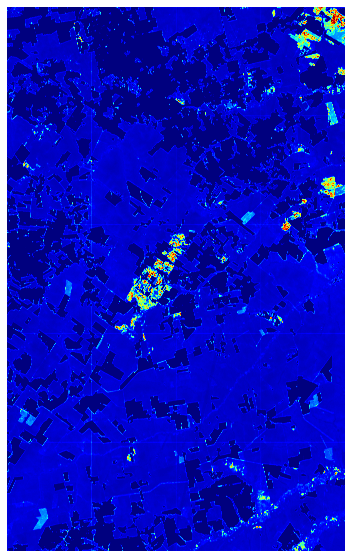

In [83]:
trainer.logger.plotFigure(trainer.uncertainty_to_show, 
            name=trainer.dataset.site + trainer.title_name + ' uncertainty evidential learning.png', figsize=(10,10), cmap='jet', savefig=True)

ic| trainer.dataset.previewLims1: array([11500, 12500,  9000, 10000])
    trainer.dataset.previewLims2: array([ 5000,  6000,  9500, 10500])
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]]): array([1], dtype=uint8)
ic| np.unique(trainer.mask_amazon_ts[lims[0]:lims[1], lims[2]:lims[3]], return_counts=True): (array([1], dtype=uint8), array([920000], dtype=int64))


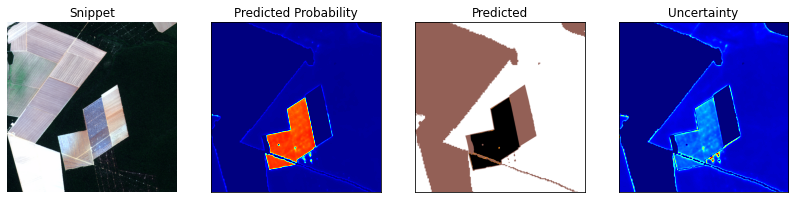

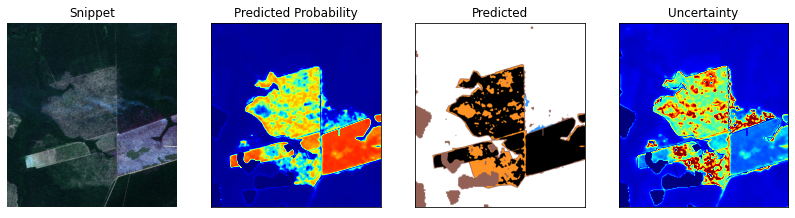

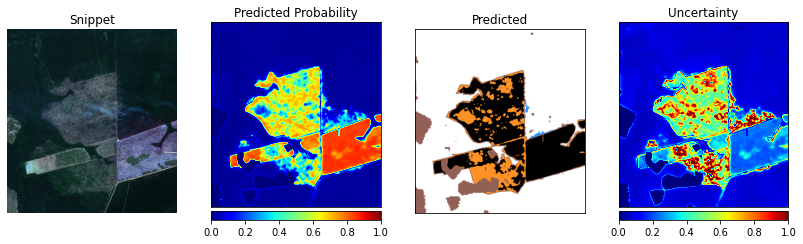

In [84]:
trainer.logger.plotCropSample(trainer)

In [85]:
trainer.logger.getStats(trainer.uncertainty)

ic| np.min(value): 0.045307055
    np.mean(value): 0.10186444
    np.max(value): 1.0


In [86]:
get_other_uncertainty_metrics = True
if get_other_uncertainty_metrics == True:
    trainer.getOtherUncertaintyMetrics()
    print(trainer.sUEO)

    print(trainer.ece_score)  

(44573051,) (44573051,)
0.49723105553104807
0
0.49723105553104807
0


In [87]:
# trainer.getUncertaintyMetrics()

In [88]:
# trainer.m

In [89]:
print(trainer.uncertainty.shape, trainer.predicted_test.shape)
print(trainer.uncertainty.dtype, trainer.predicted_test.dtype)
print(np.unique(trainer.predicted_test))
print(trainer.label_mask_current_deforestation_test.shape)


(44573051,) (44573051,)
float32 float32
[0. 1.]
(44573051,)


In [90]:
trainer.mean_prob[trainer.mask_amazon_ts == 1].shape

(70001560,)

In [91]:
uncertainty_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]

predicted_test_correct = trainer.uncertainty[trainer.predicted_test == trainer.label_mask_current_deforestation_test]
uncertainty_test_incorrect = trainer.uncertainty[trainer.predicted_test != trainer.label_mask_current_deforestation_test]


In [92]:
print(np.min(uncertainty_test_correct), np.mean(uncertainty_test_correct), np.max(uncertainty_test_correct))
print(np.min(uncertainty_test_incorrect), np.mean(uncertainty_test_incorrect), np.max(uncertainty_test_incorrect))


0.045307055 0.09768249 1.0
0.06306272 0.62843144 1.0


In [93]:
trainer.alpha_reconstructed.shape

(16800, 10432, 3)

In [94]:
trainer.alpha_unpad = trainer.alpha_reconstructed[:trainer.label_mask.shape[0], :trainer.label_mask.shape[1]]

In [95]:
trainer.alpha_unpad.shape

(16795, 10420, 3)

In [96]:
print(np.min(trainer.alpha_unpad), np.mean(trainer.alpha_unpad), np.max(trainer.alpha_unpad))

1.0 13.779037 65.47326


In [97]:
trainer.predicted_unpad.shape

(16795, 10420)

In [98]:
trainer.label_mask.shape

(16795, 10420)

In [99]:
'''
fig = plt.figure(figsize=(20,20))


plt.imshow(trainer.alpha_unpad.astype(np.uint8))
plt.plot(6600, 16500, marker='v', color="white")
plt.plot(5600, 16500, marker='v', color="white")
plt.plot(4600, 16500, marker='v', color="white")
'''

'\nfig = plt.figure(figsize=(20,20))\n\n\nplt.imshow(trainer.alpha_unpad.astype(np.uint8))\nplt.plot(6600, 16500, marker=\'v\', color="white")\nplt.plot(5600, 16500, marker=\'v\', color="white")\nplt.plot(4600, 16500, marker=\'v\', color="white")\n'

Reference 1
Predicted 1.0
Evidence [0.        3.4721966 0.       ]
Alpha [1.        4.4721966 1.       ]
trimesh.x [0.         1.         0.5        ... 0.50390625 0.50195312 0.49804688]
trimesh.y [0.         0.         0.8660254  ... 0.28416459 0.29431332 0.2875475 ]
xy2bc(xy) [1. 0. 0.]
pvals [3.1615223721458083e-13, 24.464242454327042, 3.1615223721458083e-13, 2.2051962952942374, 2.2051962952942374, 3.1615223721458083e-13, 0.19870643561979462, 9.01302802542754, 3.1615223721458083e-13, 2.205196295294239, 0.19870643561979462, 3.1615223721458083e-13, 9.01302802542754, 0.19870643561979456, 0.19870643561979479, 0.01790509427255102, 3.1615223721458083e-13, 0.19870643561979462, 15.392995251722677, 4.785616244013038, 4.785616244013042, 3.1615223721458083e-13, 0.8121484136789997, 0.017905094272551034, 2.205196295294239, 0.8121484136789988, 0.01790509427255101, 0.8121484136789988, 0.017905094272551034, 4.785616244013038, 0.19870643561979462, 0.19870643561979462, 3.1615223721458083e-13, 0.81214

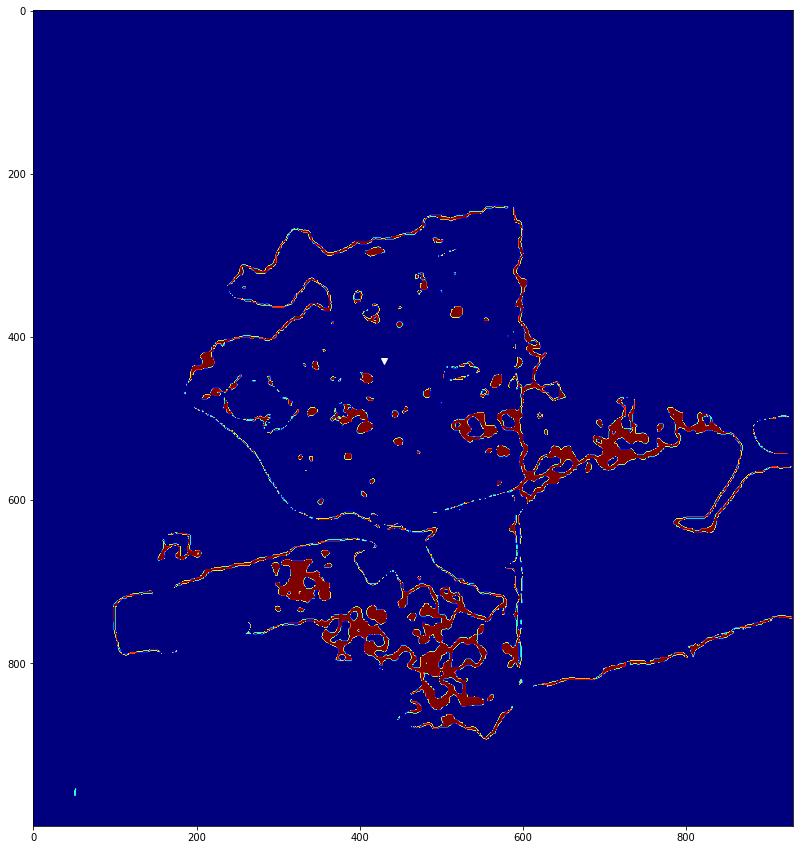

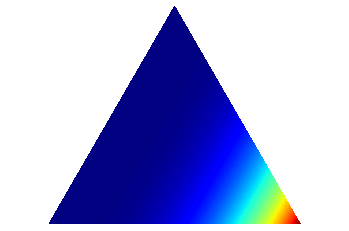

In [100]:
# lims = dataset.previewLims1
lims = dataset.previewLims2

# im = trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]]
im = trainer.uncertainty_map[lims[0]:lims[1], lims[2]:lims[3]]
plt.figure(figsize=(15,15))
plt.imshow(im.astype(np.uint8), cmap='jet')

# row, col = (550, 550) # high evidence in class 0
# row, col = (200, 600) # class 1 is higher but it has high uncertainty
# row, col = (207, 617) # class 1 is higher but it has high uncertainty
row, col = (800, 200) # high evidence in class 1
# row, col = (200, 605) # alpha 1, 1, 1

row, col = (430, 950) # alpha 1, 1, 1
row, col = (430, 430) # alpha 1, 1, 1

plt.plot(col, row, marker='v', color="white")

plt.figure()
print("Reference",trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][row, col])
print("Predicted",trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])
print("Evidence", trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col] - 1)
print("Alpha", trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])

trainer.getMassFcn(trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col])


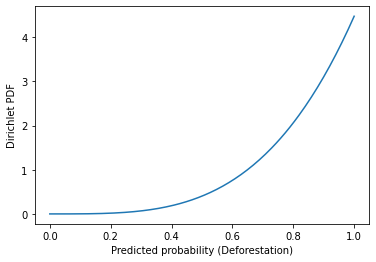

In [101]:
trainer.getMassFcn2D(trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][row, col][:2])


In [102]:


trainer.getPOIValues()


IndexError: index 950 is out of bounds for axis 1 with size 920

In [ ]:
'''
lims = dataset.previewLims1

coords = {
    "snippet_id0": [
        [550, 550], # 10,1 alpha
        [210, 610], #harder 1,1 alpha
        [207, 617], # easy 1,1 alpha
        [800, 200] # easy 1,10 alpha
    ],
    "snippet_id1": [
        [550, 115], # 10,1 alpha # I think will diverge from ensemble
        [430, 950] # Will diverge from ensemble
    ]
}

poi_alpha_info = []
for coord in coords["snippet_id0"]:
    poi_alpha_info.append(
        {"snippet_id": 0,
            "coords": coord, # 10,1 alpha
               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}
    )

poi_alpha_info
lims = dataset.previewLims2

poi_alpha_info2 = []
for coord in coords["snippet_id1"]:
    poi_alpha_info2.append(
        {"snippet_id": 1,
            "coords": coord, # 10,1 alpha
               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],
               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}
    )

poi_alpha_info.extend(poi_alpha_info2)
'''

'\nlims = dataset.previewLims1\n\ncoords = {\n    "snippet_id0": [\n        [550, 550], # 10,1 alpha\n        [210, 610], #harder 1,1 alpha\n        [207, 617], # easy 1,1 alpha\n        [800, 200] # easy 1,10 alpha\n    ],\n    "snippet_id1": [\n        [550, 115], # 10,1 alpha # I think will diverge from ensemble\n        [430, 950] # Will diverge from ensemble\n    ]\n}\n\npoi_alpha_info = []\nfor coord in coords["snippet_id0"]:\n    poi_alpha_info.append(\n        {"snippet_id": 0,\n            "coords": coord, # 10,1 alpha\n               "reference": trainer.label_mask[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],\n               "predicted": trainer.predicted_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]],\n               "alpha": trainer.alpha_unpad[lims[0]:lims[1], lims[2]:lims[3]][coord[0], coord[1]]}\n    )\n\npoi_alpha_info\nlims = dataset.previewLims2\n\npoi_alpha_info2 = []\nfor coord in coords["snippet_id1"]:\n    poi_alpha_info2.append(\n        {"

In [ ]:
poi_alpha_info

NameError: name 'poi_alpha_info' is not defined

In [ ]:
# trainer.getMassFcn(trainer.alpha_reconstructed[2500,7300])
# trainer.getMassFcn(trainer.alpha_unpad[16500,6600])


In [ ]:
# trainer.m

In [ ]:
trainer.getUncertaintyAAValues()

ic| self.uncertainty.shape: (44573051,)
    self.label_mask_current_deforestation_test.shape: (44573051,)


[0.13, 0.15, 0.2, 0.225, 0.25, 0.27, 0.3, 0.34, 0.36, 0.45, 0.55, 0.65, 0.8]
threshold 0.13


ic| label_current_deforestation_test_classified_incorrect.shape: (4957482,)
    predicted_test_classified_incorrect.shape: (4957482,)
ic| TP_H + FN_H + FP_H + TN_H: 4957482
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 4957482
    len(label_mask_current_deforestation_test): 44573051


[1.00000000e+00 2.00662185e-04 2.34905556e-06 1.11221509e-01
 8.32311341e-01 7.44450875e-01 6.86940394e-02]
threshold 0.15


ic| label_current_deforestation_test_classified_incorrect.shape: (4206692,)
    predicted_test_classified_incorrect.shape: (4206692,)
ic| TP_H + FN_H + FP_H + TN_H: 4206692
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 4206692
    len(label_mask_current_deforestation_test): 44573051


[1.00000000e+00 1.44452253e-02 2.17287640e-04 9.43774749e-02
 8.32270557e-01 7.46753812e-01 8.02445611e-02]
threshold 0.2


ic| label_current_deforestation_test_classified_incorrect.shape: (3188652,)
    predicted_test_classified_incorrect.shape: (3188652,)
ic| TP_H + FN_H + FP_H + TN_H: 3188652
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 3188652
    len(label_mask_current_deforestation_test): 44573051


[0.93592011 0.64046545 0.03852921 0.07153767 0.82725097 0.7418366
 0.10299338]
threshold 0.225


ic| label_current_deforestation_test_classified_incorrect.shape: (2801726,)
    predicted_test_classified_incorrect.shape: (2801726,)
ic| TP_H + FN_H + FP_H + TN_H: 2801726
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 2801726
    len(label_mask_current_deforestation_test): 44573051


[0.96259784 0.84897611 0.14140727 0.06285695 0.80634505 0.71310778
 0.11496626]
threshold 0.25


ic| label_current_deforestation_test_classified_incorrect.shape: (2468482,)
    predicted_test_classified_incorrect.shape: (2468482,)
ic| TP_H + FN_H + FP_H + TN_H: 2468482
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 2468482
    len(label_mask_current_deforestation_test): 44573051


[0.97032817 0.89507295 0.24462947 0.05538059 0.77724367 0.6758131
 0.12820319]
threshold 0.27


ic| label_current_deforestation_test_classified_incorrect.shape: (2250290,)
    predicted_test_classified_incorrect.shape: (2250290,)
ic| TP_H + FN_H + FP_H + TN_H: 2250290
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 2250290
    len(label_mask_current_deforestation_test): 44573051


[0.9718854  0.90507111 0.30106318 0.05048544 0.75701355 0.65133564
 0.13871154]
threshold 0.3


ic| label_current_deforestation_test_classified_incorrect.shape: (1976741,)
    predicted_test_classified_incorrect.shape: (1976741,)
ic| TP_H + FN_H + FP_H + TN_H: 1976741
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1976741
    len(label_mask_current_deforestation_test): 44573051


[0.97183453 0.90993232 0.36696711 0.04434834 0.72826843 0.61800796
 0.15431874]
threshold 0.34


ic| label_current_deforestation_test_classified_incorrect.shape: (1665222,)
    predicted_test_classified_incorrect.shape: (1665222,)
ic| TP_H + FN_H + FP_H + TN_H: 1665222
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1665222
    len(label_mask_current_deforestation_test): 44573051


[0.96803833 0.91068242 0.43929688 0.03735939 0.68912868 0.57270316
 0.17626734]
threshold 0.36


ic| label_current_deforestation_test_classified_incorrect.shape: (1533391,)
    predicted_test_classified_incorrect.shape: (1533391,)
ic| TP_H + FN_H + FP_H + TN_H: 1533391
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1533391
    len(label_mask_current_deforestation_test): 44573051


[0.962539   0.90886688 0.46565916 0.03440175 0.67488158 0.5538396
 0.18633996]
threshold 0.45


ic| label_current_deforestation_test_classified_incorrect.shape: (1081535,)
    predicted_test_classified_incorrect.shape: (1081535,)
ic| TP_H + FN_H + FP_H + TN_H: 1081535
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1081535
    len(label_mask_current_deforestation_test): 44573051


[0.91553683 0.89777183 0.55510884 0.02426433 0.6505677  0.47324643
 0.21525861]
threshold 0.55


ic| label_current_deforestation_test_classified_incorrect.shape: (762248,)
    predicted_test_classified_incorrect.shape: (762248,)
ic| TP_H + FN_H + FP_H + TN_H: 762248
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 762248
    len(label_mask_current_deforestation_test): 44573051


[0.87247441 0.88677551 0.64259942 0.0171011  0.63168837 0.33825292
 0.22078715]
threshold 0.65


ic| label_current_deforestation_test_classified_incorrect.shape: (555789,)
    predicted_test_classified_incorrect.shape: (555789,)
ic| TP_H + FN_H + FP_H + TN_H: 555789
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 555789
    len(label_mask_current_deforestation_test): 44573051


[0.84704989 0.87461932 0.69991755 0.01246917 0.62114053 0.17933143
 0.21122461]
threshold 0.8


ic| label_current_deforestation_test_classified_incorrect.shape: (365532,)
    predicted_test_classified_incorrect.shape: (365532,)
d:\Jorge\deforestation_uncertainty\src\metrics.py:296: RuntimeWarning: invalid value encountered in longlong_scalars
  precision_H = TP_H / (TP_H + FP_H)
ic| TP_H + FN_H + FP_H + TN_H: 365532
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 365532
    len(label_mask_current_deforestation_test): 44573051


[0.83231179 0.8421146  0.7357383  0.00820074        nan 0.
 0.17654851]


In [ ]:
trainer.getUncertaintyAAAuditedValues()

ic| self.uncertainty.shape: (44573051,)
    self.label_mask_current_deforestation_test.shape: (44573051,)


threshold 0.13
(44573051,) (44573051,)
cm_audited [[43721645        0]
 [    9965   841441]]
[1.         0.98829583]
threshold 0.15
(44573051,) (44573051,)
cm_audited [[43721645        0]
 [   12622   838784]]
[1.         0.98517511]
threshold 0.2
(44573051,) (44573051,)
cm_audited [[43719399     2246]
 [   18415   832991]]
[0.99731094 0.97837107]
threshold 0.225
(44573051,) (44573051,)
cm_audited [[43716967     4678]
 [   21417   829989]]
[0.99439537 0.97484514]
threshold 0.25
(44573051,) (44573051,)
cm_audited [[43715276     6369]
 [   24416   826990]]
[0.99235744 0.97132273]
threshold 0.27
(44573051,) (44573051,)
cm_audited [[43714230     7415]
 [   26885   824521]]
[0.99108705 0.96842282]
threshold 0.3
(44573051,) (44573051,)
cm_audited [[43712590     9055]
 [   30926   820480]]
[0.98908425 0.96367655]
threshold 0.34
(44573051,) (44573051,)
cm_audited [[43709296    12349]
 [   36683   814723]]
[0.98506901 0.9569148 ]
threshold 0.36
(44573051,) (44573051,)
cm_audited [[43706215    1

ic| metric_values_audited: array([[1.        , 0.98829583],
                                  [1.        , 0.98517511],
                                  [0.99731094, 0.97837107],
                                  [0.99439537, 0.97484514],
                                  [0.99235744, 0.97132273],
                                  [0.99108705, 0.96842282],
                                  [0.98908425, 0.96367655],
                                  [0.98506901, 0.9569148 ],
                                  [0.98134405, 0.95330782],
                                  [0.94816635, 0.93679044],
                                  [0.90717674, 0.91795219],
                                  [0.87682553, 0.89966362],
                                  [0.85327849, 0.86205876]])


cm_audited [[43595440   126205]
 [  117444   733962]]
[0.85327849 0.86205876]


In [ ]:
trainer.setPlotLimsForUncertaintyAA()

In [ ]:

def plotUncertaintyAA(self):

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.set_figheight(5)
    fig.set_figwidth(15)
    ax1.plot(self.m['AA']*100, self.m['precision_L']*100, 'C3-', label="Precision Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_L']*100, 'C3--', label="Recall Low Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['precision_H']*100, 'C0-', label="Precision High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m['recall_H']*100, 'C0--', label="Recall High Uncertainty")
    ax1.plot(self.m['AA']*100, self.m_audited['precision']*100, 'C2-', label="Precision Audited")
    ax1.plot(self.m['AA']*100, self.m_audited['recall']*100, 'C2--', label="Recall Audited")

    ax1.legend(loc="lower right")
    ax1.set_ylabel('Precision/recall (%)')
    ax1.set_xlabel('Audit Area (%)')
    ax1.set_ylim(self.ylim)
    ax1.set_xlim(self.xlim)
    ax1.grid()

    xs = [0, 120]
    ax1.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = 'vline_multiple - full height')

    ax2.plot(range(int(self.xlim[0]), int(self.xlim[1] + 2)), 
        np.ones(int(self.xlim[1] + 2)) * self.f1, 
        'C1:', label="F1 No Uncertainty")

    ax2.plot(self.m['AA']*100, self.m['f1_L']*100, 'C3-', label="F1 Low Uncertainty")
    ax2.plot(self.m['AA']*100, self.m['f1_H']*100, 'C0-', label="F1 High Uncertainty")
    ax2.plot(self.m['AA']*100, self.m_audited['f1']*100, 'C2-', label="F1 Audited")

    ax2.legend(loc="lower right")
    ax2.set_ylabel('F1 score (%)')
    ax2.set_xlabel('Audit Area (%)')
    ax2.set_ylim(self.ylim)
    ax2.set_xlim(self.xlim)

    ax2.grid()

    xs = [0, 120]
    ax2.vlines(x = 3, ymin = 0, ymax = max(xs),
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.plot(np.asarray(self.threshold_list), self.m['AA']*100, label="AA")
    ax3.set_ylabel('Audit Area (%)')
    ax3.set_xlabel('Uncertainty Threshold')
    ax3.grid()
    ax3.set_ylim(self.xlim)

    self.xlim_adjusted = ax3.get_xlim()
    ax3.hlines(y = 3, xmin = self.xlim_adjusted[0], xmax = self.xlim_adjusted[1],
            colors = (0.2, 0.2, 0.2),
            label = '3% AA')

    ax3.set_xlim(self.xlim_adjusted)

    # if save_figures == True:
    if True:
        plt.savefig('output/figures/recall_precision_f1_AA.png', dpi=150, bbox_inches='tight')

def plotUEO(self): 

    plt.plot(self.m['AA']*100, self.m['UEO'], label="UEO") 
    plt.grid() 
    plt.xlabel('Audit Area (%)') 
    plt.ylabel('UEO (%)') 
    plt.xlim(self.xlim)
    plt.ylim([0, 0.4])

import types

trainer.plotUncertaintyAA = types.MethodType(plotUncertaintyAA, trainer)
trainer.plotUEO = types.MethodType(plotUEO, trainer)


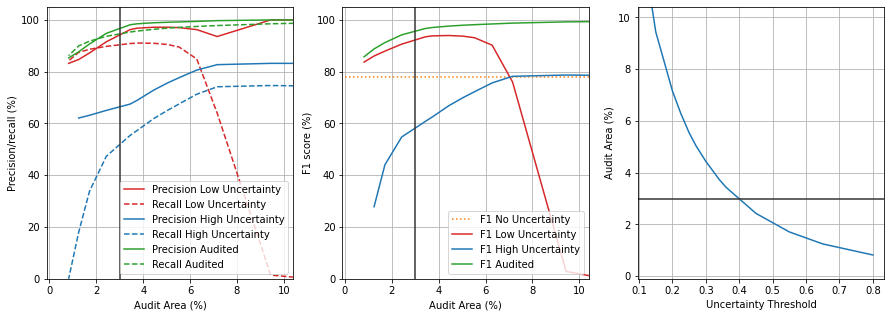

In [ ]:
trainer.plotUncertaintyAA()

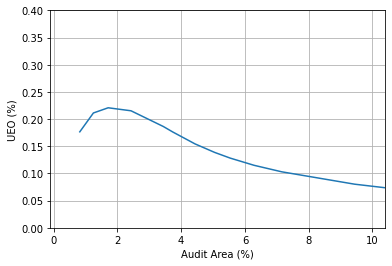

In [ ]:
trainer.plotUEO()

In [ ]:
trainer.getOptimalUncertaintyThreshold()

ic| bounds: (0.0015, 0.9985)
c:\Users\jchamorro\Anaconda3\envs\tf2\lib\site-packages\scipy\optimize\_minimize.py:783: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  warn("Method 'bounded' does not support relative tolerance in x; "


0.38232011321635484
threshold 0.38232011321635484


ic| label_current_deforestation_test_classified_incorrect.shape: (1402572,)
    predicted_test_classified_incorrect.shape: (1402572,)
ic| TP_H + FN_H + FP_H + TN_H: 1402572
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1402572
    len(label_mask_current_deforestation_test): 44573051


[0.95283272 0.90593266 0.48848728 0.03146682 0.66590432 0.53657983
 0.19601526]
0.6176798867836452
threshold 0.6176798867836452


ic| label_current_deforestation_test_classified_incorrect.shape: (613989,)
    predicted_test_classified_incorrect.shape: (613989,)
ic| TP_H + FN_H + FP_H + TN_H: 613989
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 613989
    len(label_mask_current_deforestation_test): 44573051


[0.8537266  0.87856664 0.68380773 0.01377489 0.62565801 0.23426125
 0.21528059]
0.23685977356729035
threshold 0.23685977356729035


ic| label_current_deforestation_test_classified_incorrect.shape: (2635096,)
    predicted_test_classified_incorrect.shape: (2635096,)
ic| TP_H + FN_H + FP_H + TN_H: 2635096
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 2635096
    len(label_mask_current_deforestation_test): 44573051


[0.96726575 0.87867051 0.19425045 0.05911859 0.79263936 0.69517162
 0.12117941]
0.4527708183564898
threshold 0.4527708183564898


ic| label_current_deforestation_test_classified_incorrect.shape: (1070231,)
    predicted_test_classified_incorrect.shape: (1070231,)
ic| TP_H + FN_H + FP_H + TN_H: 1070231
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1070231
    len(label_mask_current_deforestation_test): 44573051


[0.91408485 0.89751512 0.55815792 0.02401072 0.64964423 0.46965579
 0.21576926]
0.3267592074855162
threshold 0.3267592074855162


ic| label_current_deforestation_test_classified_incorrect.shape: (1761777,)
    predicted_test_classified_incorrect.shape: (1761777,)
ic| TP_H + FN_H + FP_H + TN_H: 1761777
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1761777
    len(label_mask_current_deforestation_test): 44573051


[0.97004255 0.91116081 0.41770554 0.03952561 0.70149509 0.58724468
 0.16904674]
0.39821552015070144
threshold 0.39821552015070144


ic| label_current_deforestation_test_classified_incorrect.shape: (1317815,)
    predicted_test_classified_incorrect.shape: (1317815,)
ic| TP_H + FN_H + FP_H + TN_H: 1317815
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1317815
    len(label_mask_current_deforestation_test): 44573051


[0.94406836 0.90347475 0.50285645 0.02956529 0.66287439 0.52519535
 0.2016623 ]
0.40398454176911713
threshold 0.40398454176911713


ic| label_current_deforestation_test_classified_incorrect.shape: (1288822,)
    predicted_test_classified_incorrect.shape: (1288822,)
ic| TP_H + FN_H + FP_H + TN_H: 1288822
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1288822
    len(label_mask_current_deforestation_test): 44573051


[0.94067999 0.90274268 0.50817354 0.02891483 0.66200614 0.52064999
 0.2034917 ]
0.3942262774392486
threshold 0.3942262774392486


ic| label_current_deforestation_test_classified_incorrect.shape: (1338314,)
    predicted_test_classified_incorrect.shape: (1338314,)
ic| TP_H + FN_H + FP_H + TN_H: 1338314
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1338314
    len(label_mask_current_deforestation_test): 44573051


[0.94633801 0.90406542 0.49926592 0.03002518 0.66351607 0.52812935
 0.20034316]
0.38967852738174114
threshold 0.38967852738174114


ic| label_current_deforestation_test_classified_incorrect.shape: (1362361,)
    predicted_test_classified_incorrect.shape: (1362361,)
ic| TP_H + FN_H + FP_H + TN_H: 1362361
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1362361
    len(label_mask_current_deforestation_test): 44573051


[0.94890861 0.90467077 0.49522672 0.03056468 0.66425216 0.53141276
 0.19871871]
0.39425961661990255
threshold 0.39425961661990255


ic| label_current_deforestation_test_classified_incorrect.shape: (1338156,)
    predicted_test_classified_incorrect.shape: (1338156,)
ic| TP_H + FN_H + FP_H + TN_H: 1338156
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1338156
    len(label_mask_current_deforestation_test): 44573051


[0.94632848 0.90406303 0.49929646 0.03002164 0.66350036 0.52810271
 0.20035712]
0.3952492656086869
threshold 0.3952492656086869


ic| label_current_deforestation_test_classified_incorrect.shape: (1333021,)
    predicted_test_classified_incorrect.shape: (1333021,)
ic| TP_H + FN_H + FP_H + TN_H: 1333021
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1333021
    len(label_mask_current_deforestation_test): 44573051


[0.94576241 0.90391052 0.50022081 0.02990643 0.66331351 0.52735239
 0.20068239]
0.3946376288966862
threshold 0.3946376288966862


ic| label_current_deforestation_test_classified_incorrect.shape: (1336228,)
    predicted_test_classified_incorrect.shape: (1336228,)
ic| TP_H + FN_H + FP_H + TN_H: 1336228
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1336228
    len(label_mask_current_deforestation_test): 44573051


[0.94613669 0.904001   0.49962533 0.02997838 0.66342371 0.52784174
 0.20048761]
0.3944487307351727
threshold 0.3944487307351727


ic| label_current_deforestation_test_classified_incorrect.shape: (1337188,)
    predicted_test_classified_incorrect.shape: (1337188,)
ic| TP_H + FN_H + FP_H + TN_H: 1337188
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1337188
    len(label_mask_current_deforestation_test): 44573051


[0.94623967 0.90402776 0.49945854 0.02999992 0.66345662 0.52797753
 0.20042418]
0.39441539155121924
threshold 0.39441539155121924


ic| label_current_deforestation_test_classified_incorrect.shape: (1337355,)
    predicted_test_classified_incorrect.shape: (1337355,)
ic| TP_H + FN_H + FP_H + TN_H: 1337355
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1337355
    len(label_mask_current_deforestation_test): 44573051


[0.9462513  0.90403398 0.499428   0.03000367 0.66347016 0.52800143
 0.20041148]
0.39448601915035514
threshold 0.39448601915035514


ic| label_current_deforestation_test_classified_incorrect.shape: (1336991,)
    predicted_test_classified_incorrect.shape: (1336991,)
ic| TP_H + FN_H + FP_H + TN_H: 1336991
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1336991
    len(label_mask_current_deforestation_test): 44573051
ic| self.threshold_optimal: 0.3944487307351727


[0.94621692 0.90401282 0.49948321 0.0299955  0.66345957 0.52796537
 0.20043347]


In [ ]:
snapshot = tracemalloc.take_snapshot()
display_top(snapshot, limit=20)

Top 20 lines
#1: <__array_function__ internals>:5: 15039474.2 KiB
#2: ipykernel_19108\3510209264.py:3: 14355788.8 KiB
    trainer.image_stack = trainer.image_stack[..., trainer.patchesHandler.dataset.image_channels[-1]]
#3: src\patchesHandler.py:339: 2053800.1 KiB
    alpha_reconstructed = np.zeros((h, w, 3), dtype=np.float32)
#4: trainer\base.py:347: 684600.2 KiB
    self.uncertainty_to_show = self.uncertainty_map.copy()[:self.label_mask.shape[0], :self.label_mask.shape[1]]
#5: trainer\evidential.py:535: 684600.1 KiB
    self.prob_rec = prob_reconstructed.copy()
#6: src\patchesHandler.py:338: 684600.1 KiB
    u_reconstructed = np.zeros((h, w), dtype=np.float32)
#7: trainer\evidential.py:556: 683609.1 KiB
    self.predicted_unpad = self.predicted.copy()
#8: trainer\base.py:480: 683609.1 KiB
    self.error_mask = np.abs(self.predicted_unpad - self.label_mask_current_deforestation)
#9: trainer\base.py:325: 683609.1 KiB
    self.mean_prob = self.mean_prob.copy()
#10: ipykernel_19108\20888

In [ ]:
trainer.getUncertaintyMetricsFromOptimalThreshold()

threshold 0.3944487307351727


ic| label_current_deforestation_test_classified_incorrect.shape: (1337188,)
    predicted_test_classified_incorrect.shape: (1337188,)
ic| TP_H + FN_H + FP_H + TN_H: 1337188
    len(label_mask_current_deforestation_test): 44573051
ic| TP_H + FN_H + FP_H + TN_H: 1337188
    len(label_mask_current_deforestation_test): 44573051


[0.94623967 0.90402776 0.49945854 0.02999992 0.66345662 0.52797753
 0.20042418]
threshold 0.3944487307351727
(44573051,) (44573051,)


ic| self.m_optimal: {'AA': array([0.02999992]),
                     'UEO': array([0.20042418]),
                     'f1': 78.11,
                     'f1_H': array([0.58801435]),
                     'f1_L': array([0.9246522]),
                     'precision_H': array([0.66345662]),
                     'precision_L': array([0.94623967]),
                     'recall_H': array([0.52797753]),
                     'recall_L': array([0.90402776]),
                     'recall_Ltotal': array([0.49945854])}
ic| self.m_audited_optimal: {'f1': array([0.95879246]),
                             'precision': array([0.97090636]),
                             'recall': array([0.94697712])}


cm_audited [[43697485    24160]
 [   45144   806262]]
[0.97090636 0.94697712]


{'metrics': {'precision_L': array([0.94623967]),
  'recall_L': array([0.90402776]),
  'recall_Ltotal': array([0.49945854]),
  'AA': array([0.02999992]),
  'precision_H': array([0.66345662]),
  'recall_H': array([0.52797753]),
  'UEO': array([0.20042418]),
  'f1_L': array([0.9246522]),
  'f1_H': array([0.58801435]),
  'f1': 78.11},
 'metrics_audited': {'precision': array([0.97090636]),
  'recall': array([0.94697712]),
  'f1': array([0.95879246])},
 'exp': 195}